In [13]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import plotly.graph_objects as go
import plotly.io as pio
import pickle

In [14]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.feature_selection import RFE

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [19]:
data = pd.read_csv("Crop_recommendation.csv")
data.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [20]:
data.shape
data.columns.tolist()
data.info()
data.mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


N               50.551818
P               53.362727
K               48.149091
temperature     25.616244
humidity        71.481779
ph               6.469480
rainfall       103.463655
dtype: float64

In [21]:
warnings.filterwarnings('ignore')

sns.set_style("whitegrid", {'axes.grid' : False})
pio.templates.default = "plotly_white"

In [22]:
def explore_data(df):
    print("Number of Instances and Attributes:", df.shape)
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())


In [23]:
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')

In [24]:
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [25]:
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('CART' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

In [26]:
def ensemblemodels():
    ensembles = []
    ensembles.append(('AB'   , AdaBoostClassifier()))
    ensembles.append(('GBM'  , GradientBoostingClassifier()))
    ensembles.append(('RF'   , RandomForestClassifier()))
    ensembles.append(( 'Bagging' , BaggingClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    return ensembles

In [32]:
def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()
    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines

In [33]:
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [34]:
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

In [35]:
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

In [36]:
# Load Dataset
df = pd.read_csv('Crop_recommendation.csv')

# Remove Outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

Training Accuracy Score: 99.5%
Validation Accuracy Score: 99.3%


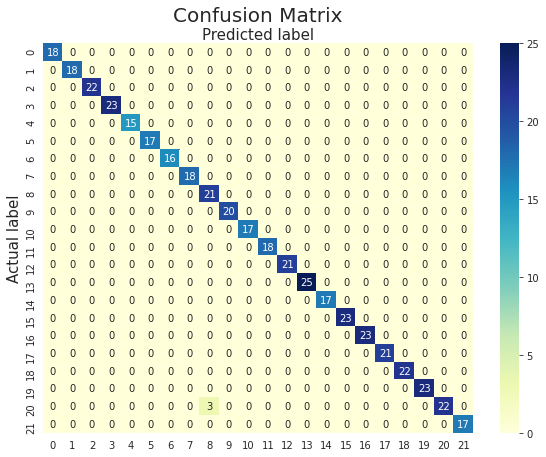

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [37]:
# Split Data to Training and Validation set
target ='label'
X_train, X_test, y_train, y_test = read_in_and_split_data(df, target)

# Train model
pipeline = make_pipeline(StandardScaler(),  GaussianNB())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

In [39]:
save_model(model, 'crop.pkl')